In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import crypten
from crypten import mpc
import crypten.communicator as comm


from sklearn.model_selection import train_test_split
from sklearn.metrics import fbeta_score

from collections import defaultdict
import os

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
df_nn = pd.read_csv("card_transdata.csv")

train_transactions, test_transactions = train_test_split(df_nn, test_size=0.2, random_state=42)

X_train_transactions = train_transactions.drop(columns=["fraud"])
y_train_transactions = torch.from_numpy(train_transactions.fraud.values).flatten(0)[:10000]
X_test_transactions = test_transactions.drop(columns=["fraud"])
y_test_transactions = torch.from_numpy(test_transactions.fraud.values).flatten(0)

scaler = StandardScaler()
X_train_transactions = torch.from_numpy(pd.DataFrame(scaler.fit_transform(X_train_transactions), columns=X_train_transactions.columns, index=X_train_transactions.index).values)
X_test_transactions = torch.from_numpy(pd.DataFrame(scaler.transform(X_test_transactions), columns=X_test_transactions.columns, index=X_test_transactions.index).values)



print(f"X_train_transactions has shape: {X_train_transactions.shape}")
print(f"y_train_transactions has shape: {y_train_transactions.shape}")
print(f"X_test_transactions has shape: {X_test_transactions.shape}")
print(f"y_test_transactions has shape: {y_test_transactions.shape}")

print(y_train_transactions)




X_train_transactions has shape: torch.Size([800000, 7])
y_train_transactions has shape: torch.Size([10000])
X_test_transactions has shape: torch.Size([200000, 7])
y_test_transactions has shape: torch.Size([200000])
tensor([0., 0., 0.,  ..., 0., 0., 0.], dtype=torch.float64)


In [3]:
class CryptenFraudDetectionModel(crypten.nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CryptenFraudDetectionModel, self).__init__()
        self.fc1 = crypten.nn.Linear(input_size, hidden_size)
        self.relu = crypten.nn.ReLU()
        self.dropout = crypten.nn.Dropout(0.5)
        self.fc2 = crypten.nn.Linear(hidden_size, num_classes)
        self.sigmoid = crypten.nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

input_size = 7
hidden_size = 64
num_classes = 1
model = CryptenFraudDetectionModel(input_size, hidden_size, num_classes)

In [4]:
crypten.init()
torch.set_num_threads(1)

In [5]:
bank1 = 0
bank2 = 1
bank3 = 2
bank4 = 3

# Specify file locations to save data for each bank
filenames = {
    "X_samples_bank1": "data/X_samples_bank1.pth",
    "X_samples_bank2": "data/X_samples_bank2.pth",
    "X_samples_bank3": "data/X_samples_bank3.pth",
    "X_samples_bank4": "data/X_samples_bank4.pth",
    "y_samples_bank1": "data/y_samples_bank1.pth",
    "y_samples_bank2": "data/y_samples_bank2.pth",
    "y_samples_bank3": "data/y_samples_bank3.pth",
    "y_samples_bank4": "data/y_samples_bank4.pth",
}




@mpc.run_multiprocess(world_size=4)
def save_all_data():   
    # Save split dataset for the 4 banks
    X_samples_bank1 = X_train_transactions[:2500]
    X_samples_bank2 = X_train_transactions[2500:5000]
    X_samples_bank3 = X_train_transactions[5000:7500]
    X_samples_bank4 = X_train_transactions[7500:10000]
    crypten.save_from_party(X_samples_bank1, filenames["X_samples_bank1"],src = bank1)
    crypten.save_from_party(X_samples_bank2, filenames["X_samples_bank2"],src = bank2)
    crypten.save_from_party(X_samples_bank3, filenames["X_samples_bank3"],src = bank3)
    crypten.save_from_party(X_samples_bank4, filenames["X_samples_bank4"],src = bank4)

    # crypten.save_from_party(X_samples_bank1, filenames["X_samples_bank1"])
    # crypten.save_from_party(X_samples_bank2, filenames["X_samples_bank2"])
    # crypten.save_from_party(X_samples_bank3, filenames["X_samples_bank3"])
    # crypten.save_from_party(X_samples_bank4, filenames["X_samples_bank4"])

    y_samples_bank1 = y_train_transactions[:2500]
    y_samples_bank2 = y_train_transactions[2500:5000]
    y_samples_bank3 = y_train_transactions[5000:7500]
    y_samples_bank4 = y_train_transactions[7500:10000]
    crypten.save_from_party(y_samples_bank1, filenames["y_samples_bank1"],src = bank1)
    crypten.save_from_party(y_samples_bank2, filenames["y_samples_bank2"],src = bank2)
    crypten.save_from_party(y_samples_bank3, filenames["y_samples_bank3"],src = bank3)
    crypten.save_from_party(y_samples_bank4, filenames["y_samples_bank4"],src = bank4)

    # crypten.save_from_party(y_samples_bank1, filenames["y_samples_bank1"])
    # crypten.save_from_party(y_samples_bank2, filenames["y_samples_bank2"])
    # crypten.save_from_party(y_samples_bank3, filenames["y_samples_bank3"])
    # crypten.save_from_party(y_samples_bank4, filenames["y_samples_bank4"])
    
    
save_all_data()


[None, None, None, None]

In [6]:
@mpc.run_multiprocess(world_size=4)
def encrypted_training():
    # Load data:
    x_bank1_enc = crypten.load_from_party(filenames['X_samples_bank1'], src=bank1)
    x_bank2_enc = crypten.load_from_party(filenames['X_samples_bank2'], src=bank2)
    x_bank3_enc = crypten.load_from_party(filenames['X_samples_bank3'], src=bank3)
    x_bank4_enc = crypten.load_from_party(filenames['X_samples_bank4'], src=bank4)

    y_bank1_enc = crypten.load_from_party(filenames['y_samples_bank1'], src=bank1)
    y_bank2_enc = crypten.load_from_party(filenames['y_samples_bank2'], src=bank2)
    y_bank3_enc = crypten.load_from_party(filenames['y_samples_bank3'], src=bank3)
    y_bank4_enc = crypten.load_from_party(filenames['y_samples_bank4'], src=bank4)

    # x_bank1_enc = crypten.load_from_party(filenames['X_samples_bank1'])
    # x_bank2_enc = crypten.load_from_party(filenames['X_samples_bank2'])
    # x_bank3_enc = crypten.load_from_party(filenames['X_samples_bank3'])
    # x_bank4_enc = crypten.load_from_party(filenames['X_samples_bank4'])

    # y_bank1_enc = crypten.load_from_party(filenames['y_samples_bank1'])
    # y_bank2_enc = crypten.load_from_party(filenames['y_samples_bank2'])
    # y_bank3_enc = crypten.load_from_party(filenames['y_samples_bank3'])
    # y_bank4_enc = crypten.load_from_party(filenames['y_samples_bank4'])
    model.encrypt()
    # Set train mode
    model.train()
    
    hist = defaultdict(list)
    # Combine the feature sets: identical to Tutorial 3
    x_combined_enc = crypten.cat([x_bank1_enc, x_bank2_enc, x_bank3_enc, x_bank4_enc], dim=0)
    y_combined_enc= crypten.cat([y_bank1_enc, y_bank2_enc, y_bank3_enc, y_bank4_enc], dim=0)
    # print(y_combined)
    crypten.print(x_combined_enc.size())
    crypten.print(y_combined_enc.size())

    loss = crypten.nn.loss.BCELoss()
    rank = comm.get().get_rank()

    # Define training parameters
    learning_rate = 0.005
    num_epochs = 1000
    batch_size = 1
    num_batches = x_combined_enc.size(0) // batch_size


    label_eye = torch.eye(2)
    
    for i in range(num_epochs):   
    
    # for batch in range(num_batches):
        # define the start and end of the training mini-batch
        # start, end = batch * batch_size, (batch + 1) * batch_size
                                
        # construct CrypTensors out of training examples / labels
        x_train = x_combined_enc
        x_train.requires_grad = True

        y_train = y_combined_enc
        y_train.requires_grad = True

        # perform forward pass:
        output = model(x_train)
        loss_value = loss(output, y_train.unsqueeze(1))
        
        # set gradients to "zero" 
        model.zero_grad()

        # perform backward pass: 
        loss_value.backward()

        # update parameters
        model.update_parameters(learning_rate)
        
        # Print progress every batch:
        batch_loss = loss_value.get_plain_text()
        crypten.print(f"\tEpoch {i} of {num_batches} Loss {batch_loss.item():.4f}")
        if i % 10 == 0:
            f2_score = fbeta_score(np.where(output.get_plain_text() > 0.5, 1, 0), y_train.get_plain_text(), beta=0.5)
            accuracy = accuracy_score(np.where(output.get_plain_text() > 0.5, 1, 0), y_train.get_plain_text())
            crypten.print(f"\tEpoch {(i)} of {num_batches} f2 score {f2_score:.4f}")
            crypten.print(f"\tEpoch {(i)} of {num_batches} accuracy score {accuracy:.4f}")
            hist["train_cost"].append(batch_loss.item())
            hist["train_f2"].append(f2_score)
    return hist

hist = encrypted_training()

torch.Size([10000, 7])
torch.Size([10000])
	Epoch 0 of 10000 Loss 0.7589
	Epoch 0 of 10000 f2 score 0.2726
	Epoch 0 of 10000 accuracy score 0.3448
	Epoch 1 of 10000 Loss 0.7559
	Epoch 2 of 10000 Loss 0.7515
	Epoch 3 of 10000 Loss 0.7465
	Epoch 4 of 10000 Loss 0.7415
	Epoch 5 of 10000 Loss 0.7381
	Epoch 6 of 10000 Loss 0.7355
	Epoch 7 of 10000 Loss 0.7318
	Epoch 8 of 10000 Loss 0.7273
	Epoch 9 of 10000 Loss 0.7214
	Epoch 10 of 10000 Loss 0.7180
	Epoch 10 of 10000 f2 score 0.2384
	Epoch 10 of 10000 accuracy score 0.4937
	Epoch 11 of 10000 Loss 0.7137
	Epoch 12 of 10000 Loss 0.7104
	Epoch 13 of 10000 Loss 0.7079
	Epoch 14 of 10000 Loss 0.7051
	Epoch 15 of 10000 Loss 0.7003
	Epoch 16 of 10000 Loss 0.6958
	Epoch 17 of 10000 Loss 0.6932
	Epoch 18 of 10000 Loss 0.6882
	Epoch 19 of 10000 Loss 0.6865
	Epoch 20 of 10000 Loss 0.6821
	Epoch 20 of 10000 f2 score 0.2224
	Epoch 20 of 10000 accuracy score 0.6564
	Epoch 21 of 10000 Loss 0.6793
	Epoch 22 of 10000 Loss 0.6763
	Epoch 23 of 10000 Loss 0.67

In [ ]:
def plot_validation_curve(data, ax=None, ylim=None):
    if ax is None:
        fig, ax = plt.subplots()
        ax.set_title("Validation Curve")
        ax.set_ylabel("Cost")
    if ylim is not None:
        ax.set_ylim(ylim)
    ax.set_xlabel("Epochs")
    ax.plot(data)


def plot_validation_curves(hist, ylim=None):
    fig, ax = plt.subplots(ncols=2, figsize=(16,5))

    ax[0].set_title("Train Cost")
    ax[0].set_ylabel("Cost")
    plot_validation_curve(hist['train_cost'], ax[0], ylim)

    ax[1].set_title("Train F2")
    ax[1].set_ylabel("F2")
    ax[1].set_ylim(-1, 1)
    plot_validation_curve(hist['train_f2'], ax[1])

    plt.tight_layout()

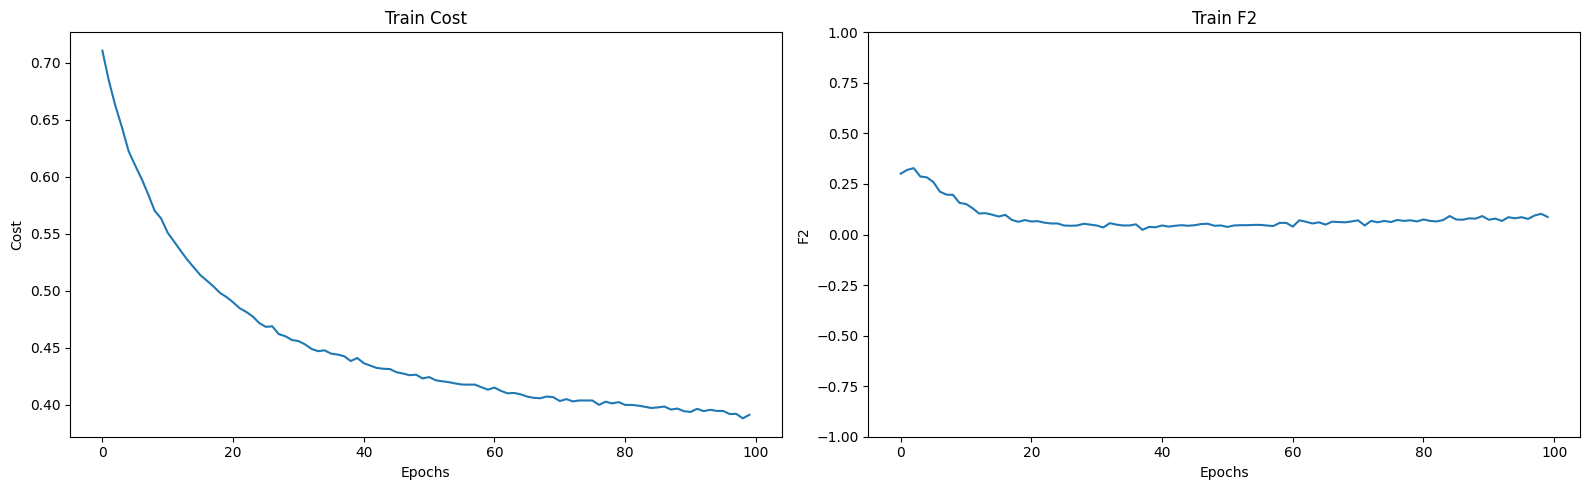

In [ ]:
plot_validation_curves(hist)

In [ ]:
model.eval()
output_test = model(crypten.cryptensor(X_test_transactions))
output_test = output_test.get_plain_text()

f2_test = fbeta_score(np.where(output_test > 0.5, 1, 0), y_test_transactions, beta=0.5)
print(f2_test)
print(accuracy_score(np.where(output_test > 0.5, 1, 0), y_test_transactions))

0.05222024364736143
0.915245
